```yaml
author: Aaron Becker
title: Measuring English phoneme similarity from phonetic features
slug: measuring-english-phoneme-similarity-from-phonetic-features
description: How can we quantify similarity between two pronunciations? Theoretical phonetics provides one approach, explored and implemented here.
publishDate: 2025-01-09T12:00:00Z
draft: false
tags:
    - nameplay
    - linguistics
```

## How does this sound to you?
There is no universally applicable, objective way to measure the distance between two phonemes[^1]. Intuitively, it seems like some sounds are definitely closer than others--for example, the consonants "t" and "p" sound more similar to a native English speaker than "t" and "s". But how would you rank whether "t" is closer to "g" or "m"? And how would you go about comparing consonants to vowels?

## Motivation
I'm working on a project to [identify names with the same pronunciation](https://nameplay.org) in order to create name popularlity rankings and visualizations that combine different spelling variations of the same name. As a first step, I prompted a generative AI model to produce phonetic transcriptions of name pronunciations. In order to group names, and recommend similar-sounding names, I needed a way to rank pronunciation similarity. This turned out to be much more difficult than I expected.

## Overview
There are two related questions to consider here:
* Which phoneme sounds do you consider most similar, and how do you quantify that similarity or difference?
* How do you **align** phonetic transcriptions of different lengths? What determines which sounds are considered "inserted" or "deleted" when comparing pronunciations of different lengths?

### Measuring phoneme similarity
Broadly, there are three major approaches that have been used to measure similarity between English phonemes, listed in order of decreasing effort and increasing robustness:
* **Confusability**: in experimental settings, how often are different sounds confused by listeners? Administering a controlled experiment is time-consuming and expensive. Moreover, judgments of sounds in isolation don't generalize to the real world, so devising an experiment with a sample that's representative of everyday speech would require impractically long lab sessions.
* **Expert judgment**: how many phonological features, like place of articulation, manner of articulation, and voicing, are shared between two phonemes? Even understanding what these features are requires a lot of domain-specific knowledge, let alone calibrating a scoring system based on them.
* **Substitution**: how often is one sound substituted for another in phonetic transcriptions of the same word? Computing substitution frequencies from words with multiple human-annotated pronunciations in open-source pronouncing dictionaries is basically a sequence alignment problem.
    * **Dictionary creators, however, rarely assign more than one "correct" pronunciation to a given word;** the whole point of a pronunciation dictionary is to provide a single, canonical pronunciation for each word. Moreover, experts are often biased towards a "standard" accent that glosses over real-world regional variations in the way people speak.
    * To supplement the limited pool of "gold standard" pronunciation variations, I turned to an approach that researchers have called **"decoder error."** Decoder error looks at how often a model-based system substitutes one phoneme for another when generating phonetic transcriptions for a given word. *Uncertainty in the model's output reflects uncertainty in the model's training data*, providing an empirical way to measure phoneme interchangeability.


[^1]: [Phonemes](https://en.wikipedia.org/wiki/Phoneme) are the smallest units of sound in a language.

:::tip[download the code for this article]
<a href="/notebook_data/phoneme-similarity-matrix-from-phonetic-features.ipynb" title="Jupyter notebook version of this article" type="application/x-ipynb+json">Download this article as a Jupyter notebook</a>. I'm using python 3.10.15, polars 1.8.2, seaborn 0.13.2, adjustText 1.3.0, and matplotlib 3.9.2.

[Download the CSV of phoneme features](/notebook_data/ruiz_phoneme_features.csv)
:::

In [1]:
from pathlib import Path
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from contextlib import redirect_stdout
from adjustText import adjust_text
from scipy import stats
import requests
# apply seaborn plotting theme
sns.set_theme(style='whitegrid')

## Phonological Phoneme Similarity
The phoneme similarity features I'm using are based on work by [Ruiz et al](https://sites.google.com/site/similaritymatrices/phonological-features/english-feature-specifications) for a 2014 paper on aligning transcripts to audio in an automatic subtitling system[^2]. I copied the matrix into a CSV, added the missing `ZH` phoneme, flattened columns, and added back the `Rhotic` feature from the [Kondrak 2002 thesis](https://webdocs.cs.ualberta.ca/~kondrak/papers/thesis.pdf) which Ruiz et al. derived their feature set from.

I'm using the [ARPAbet phoneme set](https://en.wikipedia.org/wiki/ARPABET), which is designed specifically to cover sounds used in American English. This is the format used by the [CMU Pronouncing Dictionary](https://en.wikipedia.org/wiki/CMU_Pronouncing_Dictionary), which is the most comprehensive and widely used source of human-annotated phonetic transcriptions freely availble to the public. ARPAbet has the major advantage representing pronunciations entirely in ASCII (regular letters and numbers), which makes it more accessible and easier to work with than specialist transcription systems like IPA.

[^2]: Ruiz, Pablo, Aitor Álvarez, and Haritz Arzelus. 2014. “Phoneme Similarity Matrices to Improve Long Audio Alignment for Automatic Subtitling.” International Conference on Language Resources and Evaluation, May, 437–42.

In [2]:
ruiz_features = pl.read_csv(Path.cwd().joinpath('ruiz_phoneme_features.csv'))
with pl.Config(tbl_rows=ruiz_features.height):
    display(ruiz_features)

shape: (39, 13)
┌─────────┬───────┬─────────────────┬─────────────┬───┬──────┬───────┬──────┬────────┐
│ Phoneme ┆ Vowel ┆ Place           ┆ Place_Score ┆ … ┆ Back ┆ Round ┆ Long ┆ Rhotic │
│ ---     ┆ ---   ┆ ---             ┆ ---         ┆   ┆ ---  ┆ ---   ┆ ---  ┆ ---    │
│ str     ┆ i64   ┆ str             ┆ i64         ┆   ┆ i64  ┆ i64   ┆ i64  ┆ i64    │
╞═════════╪═══════╪═════════════════╪═════════════╪═══╪══════╪═══════╪══════╪════════╡
│ AA      ┆ 100   ┆ velar           ┆ 60          ┆ … ┆ 50   ┆ 0     ┆ 100  ┆ 0      │
│ AE      ┆ 100   ┆ palatal         ┆ 70          ┆ … ┆ 100  ┆ 0     ┆ 0    ┆ 0      │
│ AH      ┆ 100   ┆ velar           ┆ 60          ┆ … ┆ 50   ┆ 0     ┆ 0    ┆ 0      │
│ AO      ┆ 100   ┆ velar           ┆ 60          ┆ … ┆ 50   ┆ 100   ┆ 100  ┆ 0      │
│ AW      ┆ 100   ┆ velar           ┆ 62          ┆ … ┆ 30   ┆ 40    ┆ 100  ┆ 0      │
│ AY      ┆ 100   ┆ palatal         ┆ 70          ┆ … ┆ 70   ┆ 0     ┆ 100  ┆ 0      │
│ B       ┆ 0     ┆ bilabial        ┆ 100         ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ CH      ┆ 0     ┆ palato-alveolar ┆ 75          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ D       ┆ 0     ┆ alveolar        ┆ 85          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ DH      ┆ 0     ┆ dental          ┆ 90          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ EH      ┆ 100   ┆ velar           ┆ 60          ┆ … ┆ 100  ┆ 0     ┆ 0    ┆ 0      │
│ ER      ┆ 100   ┆ velar           ┆ 60          ┆ … ┆ 50   ┆ 0     ┆ 100  ┆ 100    │
│ EY      ┆ 100   ┆ palatal         ┆ 70          ┆ … ┆ 100  ┆ 0     ┆ 100  ┆ 0      │
│ F       ┆ 0     ┆ labiodental     ┆ 95          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ G       ┆ 0     ┆ velar           ┆ 60          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ HH      ┆ 0     ┆ glottal         ┆ 10          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ IH      ┆ 100   ┆ palatal         ┆ 70          ┆ … ┆ 100  ┆ 0     ┆ 0    ┆ 0      │
│ IY      ┆ 100   ┆ palatal         ┆ 70          ┆ … ┆ 100  ┆ 0     ┆ 100  ┆ 0      │
│ JH      ┆ 0     ┆ palato-alveolar ┆ 75          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ K       ┆ 0     ┆ velar           ┆ 60          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ L       ┆ 0     ┆ alveolar        ┆ 85          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ M       ┆ 0     ┆ bilabial        ┆ 100         ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ N       ┆ 0     ┆ alveolar        ┆ 85          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ NG      ┆ 0     ┆ velar           ┆ 60          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ OW      ┆ 100   ┆ velar           ┆ 62          ┆ … ┆ 0    ┆ 100   ┆ 100  ┆ 0      │
│ OY      ┆ 100   ┆ palatal         ┆ 64          ┆ … ┆ 40   ┆ 0     ┆ 0    ┆ 0      │
│ P       ┆ 0     ┆ bilabial        ┆ 100         ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ R       ┆ 0     ┆ alveolar        ┆ 85          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ S       ┆ 0     ┆ alveolar        ┆ 85          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ SH      ┆ 0     ┆ palato-alveolar ┆ 75          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ T       ┆ 0     ┆ alveolar        ┆ 85          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ TH      ┆ 0     ┆ dental          ┆ 90          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ UH      ┆ 100   ┆ velar           ┆ 60          ┆ … ┆ 0    ┆ 0     ┆ 0    ┆ 0      │
│ UW      ┆ 100   ┆ velar           ┆ 60          ┆ … ┆ 0    ┆ 100   ┆ 100  ┆ 0      │
│ V       ┆ 0     ┆ labiodental     ┆ 95          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ W       ┆ 0     ┆ velar+bilabial  ┆ 80          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ Y       ┆ 0     ┆ palatal         ┆ 60          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ Z       ┆ 0     ┆ alveolar        ┆ 85          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
│ ZH      ┆ 0     ┆ palato-alveolar ┆ 75          ┆ … ┆ null ┆ null  ┆ null ┆ null   │
└─────────┴───────┴─────────────────┴─────────────┴───┴──────┴───────┴──────┴────────┘

## Feature-based similarity scoring
These features, like "place of articulation" and "manner of articulation", come from a field of study known as Articulatory Phonetics and convey different aspects of how sounds are formed during speech by the human vocal tract. This [article from the University of Sheffield's Center for Linguistics Research](https://www.sheffield.ac.uk/linguistics/home/all-about-linguistics/about-website/branches-linguistics/phonetics/what-do-phoneticians-study/articulatory) provides a concise overview that I found helpful. 

Using these phonological features to score similarity between two phonemes requires considering different sets of features when comparing only vowels vs. comparisons that involve a consonant.

[Greg Kondrak's](https://webdocs.cs.ualberta.ca/~kondrak/) thesis explains why each set of features is relevant for each comparison type. I modified the "salience" weights used for each set of features to scale the scores between `[0, 100]`, to make the numbers friendlier to work with during calibration. I also added a novel penalty term to reflect my intuition that **vowels are more likely to be swapped than consonants among different pronunciations of the same term**.

*Every aspect of feature-based scoring requires some manual calibration; the values I arrived at were derived from the Ruiz paper as well as Kondrak's thesis, with some additional manual tuning.* As with any system incoroporating human judgment, subjectivity is inescapable. I have done my best to synthesize the existing academic research on feature-based phoneme similarity into a single, consistent scoring system.

### additional lit review (skippable)
Bailey and Hahn (2005) contrast feature-based phoneme similarity scores and empirical confusability scores, finding that feature-based scores better predict the judgments of listeners in their own laboratory experiments. Bailey and Hahn (2005) identify Place, Manner, Voicing and Sonority as the four phonetic features that best distinguish phonemes and propose using a simple count of the number of features that differ between two phonemes as a measure of phoneme difference. 

The most significant limitation of BH's work is that it only considers consonants; given that vowel sounds are swapped out more often than consonants in name pronunciations (consider "Aaron" and "Erin"), this limitation renders their approach unsuitable for my purposes.

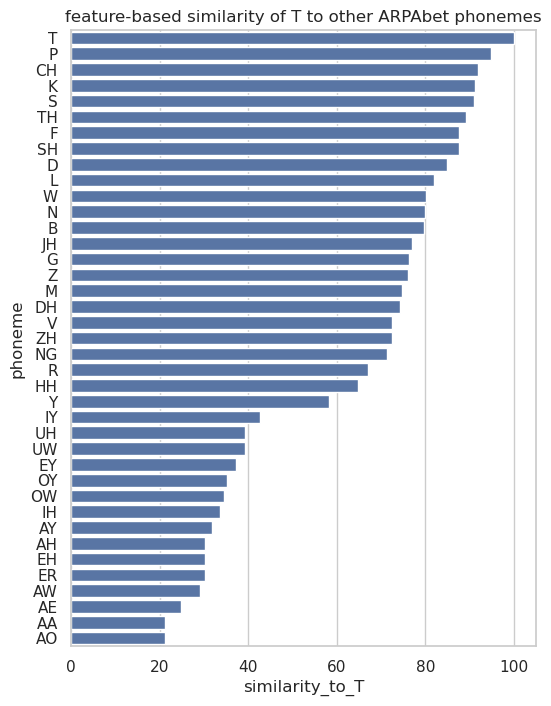

In [3]:
phonemes = ruiz_features['Phoneme'].to_list()

# convert features into a dictionary by phoneme
ruiz_features_dict = {row['Phoneme']: row for row in ruiz_features.rows(named=True)}

# columns and corresponding weights for scoring similarity between two vowels
salience_weights_v2v = {
    "Place_Score": 0.15,
    "Manner_Score": 0.15,
    "High": 0.1,   
    "Back": 0.1,
    "Round": 0.1,
    "Long": 0.3,
    'Rhotic': 0.1,
}
# columns and corresponding weights for scoring similarity between two consonants, or a consonant and a vowel
salience_weights_c2c_c2v = {
    "Vowel": 0.1, # penalty for comparing a vowel to a consonant or vice versa
    "Place_Score": 0.35,
    "Manner_Score": 0.45,
    "Voiced": 0.15,
    "Nasal": 0.05,
}

# base score is the maximum possible score (self-similarity).
# all feature differences are scaled by the salience weights and subtracted from the base score.
base_score = 100

def phonetic_feature_based_similarity_score(ph1, ph2):
    features1 = ruiz_features_dict[ph1]
    features2 = ruiz_features_dict[ph2]    
    # recall: values other than 0 are True in Python
    if features1['Vowel'] and features2['Vowel']:
        salience_weights = salience_weights_v2v
    else:
        salience_weights = salience_weights_c2c_c2v
    score = base_score
    for field, weight in salience_weights.items():
        score -= weight * abs(features1[field] - features2[field])    
    return score

# test our intuition from earlier: what phonemes are most similar to "T"?
test_phoneme = 'T'
test_similarities = [(p, phonetic_feature_based_similarity_score(test_phoneme, p)) for p in phonemes]
test_similarities = pl.DataFrame(test_similarities, orient='row', schema=['phoneme', f'similarity_to_{test_phoneme}'])\
    .sort(f'similarity_to_{test_phoneme}', descending=True)
plt.figure(figsize=(6, 8))
sns.barplot(data=test_similarities, x=f'similarity_to_{test_phoneme}', y='phoneme', orient='y')
plt.title(f'feature-based similarity of {test_phoneme} to other ARPAbet phonemes')
plt.show()

We can use feed similarity scores produced by this function into a hierarchical clustering model to test whether the phonemes cluster into groups that make intuitive sense.

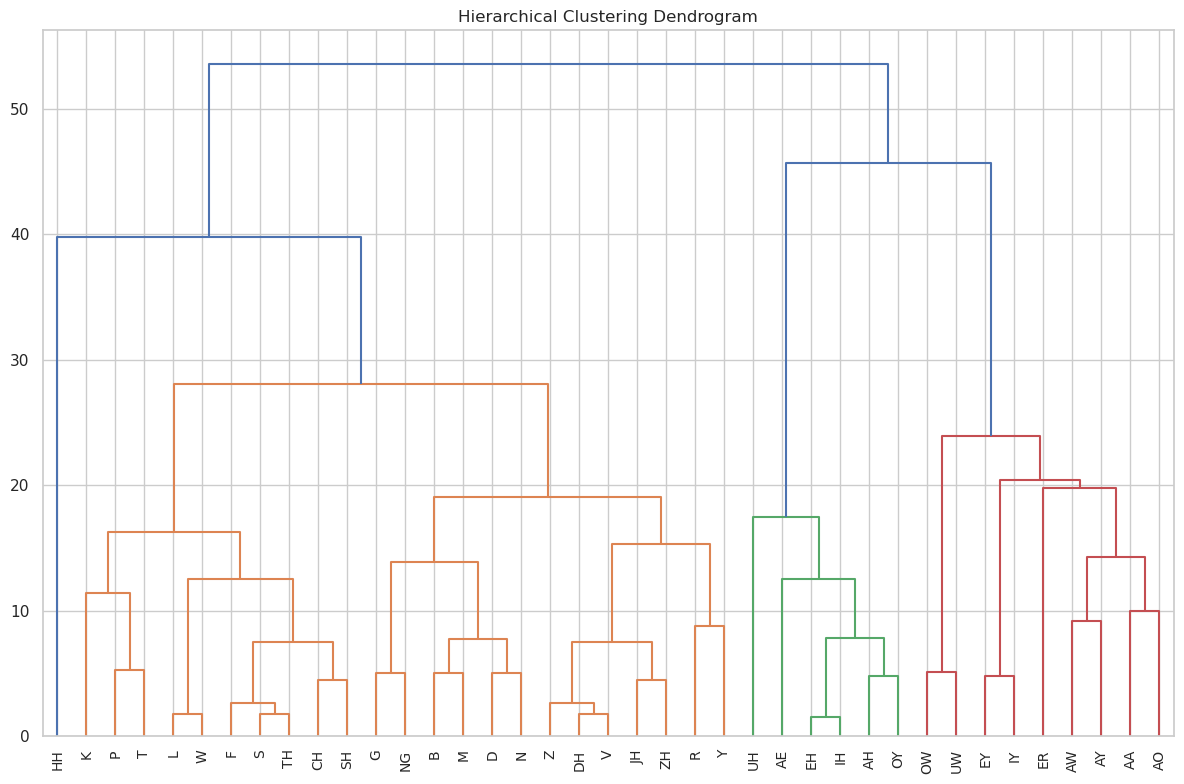

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage

# compute the distance matrix
distance_matrix = np.zeros((len(phonemes), len(phonemes)))
for i, phoneme1 in enumerate(phonemes):    
    for j, phoneme2 in enumerate(phonemes):
        if phoneme1 == phoneme2:
            continue
        distance_matrix[i, j] = 100 - phonetic_feature_based_similarity_score(phoneme1, phoneme2)

# Convert to condensed form (1D array of upper triangular elements) that `linkage` can use
condensed_dist = distance_matrix[np.triu_indices(len(phonemes), k=1)]

# perform hierarchical clustering
Z = linkage(condensed_dist, method='average')

# plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z, 
    labels=phonemes, 
    orientation='top',
    leaf_rotation=90,  # Rotate labels for better readability
    leaf_font_size=10
)
plt.title('Hierarchical Clustering Dendrogram')
plt.tight_layout()  # Adjust margins to prevent label cutoff
plt.show()

In [5]:
# we want to use the CMUdict version that includes transcriptions for all Vitz and Wilkers words
cmudict_text = requests.get('https://github.com/aparrish/phonetic-similarity-vectors/blob/master/cmudict-0.7b-with-vitz-nonce?raw=true').text

# parse CMUdict file into a dictionary
def load_cmu_dict(cmudict_text):
    """"""
    cmudict = {}    
    # each line is a word followed by a space and then a phoneme string.
    # comments follow the phoneme string and are preceded a space and a `#`.
    # words with multiple pronunciations are listed multiple times, 
    #   with a number in parentheses after the word.
    # we'll parse these into a dictionary where the key is the word,
    #   and the value is a list of phoneme strings.
    for line in cmudict_text.split('\n'):
        # ignore header lines starting with `;;;`
        if line.startswith(';;;'):
            continue
        # ignore empty lines
        if not line:
            continue
        # ignore lines that start with a non-word character 
        # (transcriptions for special characters are not relevant to our purposes)
        if not line[0].isalpha():
            continue
        word, phonemes = line.strip().split(' ', 1)
        # remove comments
        if '#' in phonemes:
            phonemes, _ = phonemes.split('#', 1)
        # remove multiple pronunciation identification
        if '(' in word:
            word, _ = word.split('(', 1)
        if word in cmudict:
            if phonemes not in cmudict[word]:
                cmudict[word].append(phonemes)
        else:
            cmudict[word] = [phonemes]
    return cmudict


cmudict = load_cmu_dict(cmudict_text)
# convert into a polars dataframe, remove stress marks and split into phonemes
cmudict_df = pl.DataFrame(zip(cmudict.keys(), cmudict.values()), schema=['word', 'phonemes'])\
    .explode('phonemes').with_columns(
        pl.col('phonemes').str.strip_chars().alias('phonemes_raw'),
        pl.col('phonemes').str.strip_chars().str.replace_all(r'\d', '').str.split(' ')
    ).unique(maintain_order=True) # some pronunciations differ only in stress marks, collapse duplicates
print(f'loaded {cmudict_df.height} pronunciations from CMUdict')

# map phonemes to indices, accounting for gap penalty in first row and column
phoneme_to_index = {p: i + 1 for i, p in enumerate(phonemes)}
# map phonemes to indices
cmudict_df = cmudict_df.with_columns(pl.col('phonemes').list.eval(pl.element().replace(phoneme_to_index).cast(pl.UInt16)).alias('phoneme_indices'))
cmudict_df.head()

loaded 133786 pronunciations from CMUdict


shape: (5, 4)
┌──────┬─────────────┬──────────────┬─────────────────┐
│ word ┆ phonemes    ┆ phonemes_raw ┆ phoneme_indices │
│ ---  ┆ ---         ┆ ---          ┆ ---             │
│ str  ┆ list[str]   ┆ str          ┆ list[u16]       │
╞══════╪═════════════╪══════════════╪═════════════════╡
│ A    ┆ ["AH"]      ┆ AH0          ┆ [3]             │
│ A    ┆ ["EY"]      ┆ EY1          ┆ [13]            │
│ A'S  ┆ ["EY", "Z"] ┆ EY1 Z        ┆ [13, 38]        │
│ A.   ┆ ["EY"]      ┆ EY1          ┆ [13]            │
│ A.'S ┆ ["EY", "Z"] ┆ EY1 Z        ┆ [13, 38]        │
└──────┴─────────────┴──────────────┴─────────────────┘

In [6]:
import numba as nb

@nb.njit(cache=True, nogil=True, fastmath=True)
def sequence_similarity_from_matrix(x: np.ndarray[np.uint16], 
                                    y: np.ndarray[np.uint16],
                                    weight_matrix: np.ndarray[np.float32, np.float32],
                                    normalize: bool = True) -> np.float32:
    """
    Scoring portion of Needleman-Wunsch algorithm, without traceback.
    This implementation uses a 2D matrix with an additional row and column for the gap scores.
    It is possible to use Hirschberg's algorithm to reduce memory requirement from O(n^2) to O(n),
        but this has no impact on runtime averaged across multiple trial runs (may actually be slower), 
        and we're not memory-bound (sequences are short).
    :param x: First sequence to align, numpy array of integer phoneme indices
    :param y: Second sequence to align, numpy array of integer phoneme indices
    :param weight_matrix: 2D array of scores for phoneme substitutions. 
        First row and column are gap scores. Diagonal scores are match scores. Off-diagonal scores are substitution scores. 
    :return: Score of the alignment
    """
    nx = x.shape[0]
    ny = y.shape[0]
    F = np.empty((nx + 1, ny + 1), dtype=np.float32)
    F[0, 0] = 0.0
    # precompute indices for faster iteration
    x_indices = np.arange(1, nx + 1)
    y_indices = np.arange(1, ny + 1)
    # Initialize the first row and the first column of the F matrix
    # always read gap score from the first row (first column is the same)
    for i in x_indices:
        F[i, 0] = F[i-1, 0] + weight_matrix[0, x[i-1]]
    for j in y_indices:
        F[0, j] = F[0, j-1] + weight_matrix[0, y[j-1]]
    # compute scores for all pairs of pronunciations
    for i in x_indices:
        for j in y_indices:
            match = F[i-1,j-1] + weight_matrix[x[i-1], y[j-1]]
            gap_x = F[i-1,j] + weight_matrix[0, x[i-1]]
            gap_y = F[i,j-1] + weight_matrix[0, y[j-1]]
            F[i,j] = max(match, gap_x, gap_y)
    # normalize by length of longer sequence if requested
    if normalize:
        return F[nx, ny] / max(nx, ny)
    return F[nx, ny]

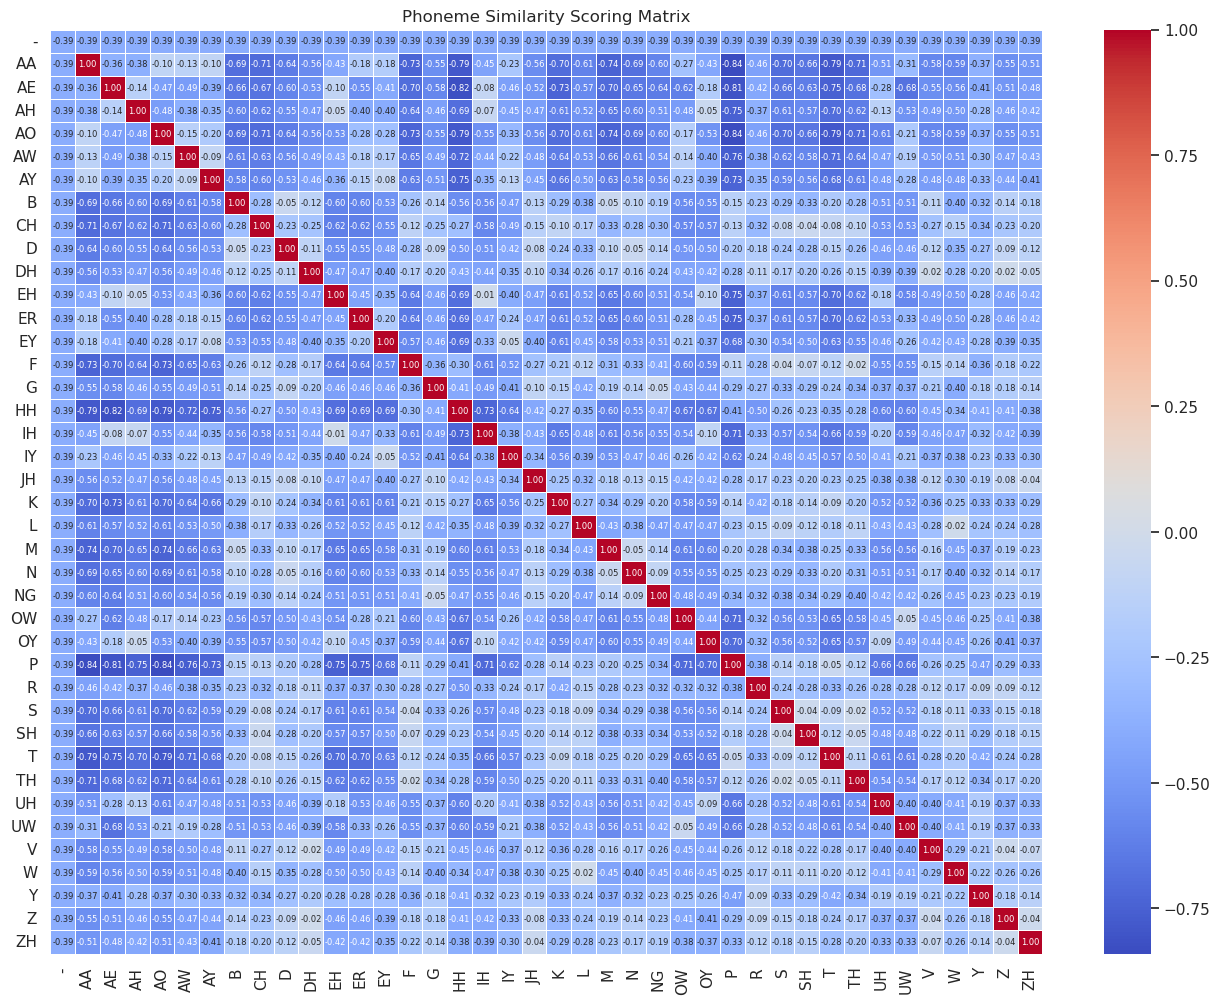

In [7]:
# build NW substitution weight matrix from our feature-based similarity scores
substitution_matrix = np.zeros((len(phonemes) + 1, len(phonemes) + 1))
for i, phoneme1 in enumerate(phonemes):
    i += 1
    for j, phoneme2 in enumerate(phonemes):
        j += 1
        score = phonetic_feature_based_similarity_score(phoneme1, phoneme2)
        if phoneme1 != phoneme2:
            # mismatch scores are <similarity score> - 100, 
            #   so that substitutions between more similar pairs incur a smaller penalty
            score -= base_score
        substitution_matrix[i, j] = score

# divide by base_score to get scores in [0, 1]
substitution_matrix = substitution_matrix / base_score

# first row and column are gap scores
# find average of off-diagonal values
avg_mismatch = np.mean(substitution_matrix[1:, 1:][np.triu_indices(len(phonemes), k=1)])
substitution_matrix[0, :] = substitution_matrix[:, 0] = avg_mismatch

# also try a baesline matrix; -1 everywhere except the diagonal
baseline_matrix = np.full((len(phonemes) + 1, len(phonemes) + 1), -1)
baseline_matrix[np.diag_indices(len(phonemes))] = 1

plt.figure(figsize=(16, 12))
sns.heatmap(substitution_matrix, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, linecolor='white',
            xticklabels=['-'] + phonemes, yticklabels=['-'] + phonemes,
            annot=True, annot_kws={'size': 6})
plt.title('Phoneme Similarity Scoring Matrix')
plt.show()


In [8]:
# load evaluation data
vw_data = pl.read_csv('https://github.com/zouharvi/pwesuite/blob/master/data/human_similarity.csv?raw=true')
print(f'loaded {vw_data.height} rows from Vitz and Wilkers evaluation data')
# join with cmudict to get phoneme indices
vw_data = vw_data.join(cmudict_df.select(pl.col('word').str.to_lowercase(), 
                                         pl.col('phonemes_raw').alias('phonemes_raw_1'),
                                         pl.col('phoneme_indices').alias('phoneme_indices_1')), 
                       left_on='word1', right_on='word', how='left')
vw_data = vw_data.join(cmudict_df.select(pl.col('word').str.to_lowercase(), 
                                         pl.col('phonemes_raw').alias('phonemes_raw_2'),
                                         pl.col('phoneme_indices').alias('phoneme_indices_2')), 
                       left_on='word2', right_on='word', how='left')
# word1 is the comparison word, word2 is the reference word.
# some word1 entries are nonces (coinages); if not in CMU dictionary we can drop them.
vw_missing = vw_data.filter(pl.col('phoneme_indices_1').is_null() | pl.col('phoneme_indices_2').is_null())
print(f'missing pronunciations for {vw_missing.select(pl.col("word1").unique()).to_series().to_list()}')
vw_data = vw_data.filter(pl.col('phoneme_indices_1').is_not_null() & pl.col('phoneme_indices_2').is_not_null())
vw_data.head()

loaded 100 rows from Vitz and Wilkers evaluation data
missing pronunciations for ['belation']


shape: (5, 8)
┌─────────┬───────┬─────────────┬──────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ word1   ┆ word2 ┆ vw_predicte ┆ obtained ┆ phonemes_ra ┆ phoneme_ind ┆ phonemes_ra ┆ phoneme_ind │
│ ---     ┆ ---   ┆ d           ┆ ---      ┆ w_1         ┆ ices_1      ┆ w_2         ┆ ices_2      │
│ str     ┆ str   ┆ ---         ┆ f64      ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│         ┆       ┆ f64         ┆          ┆ str         ┆ list[u16]   ┆ str         ┆ list[u16]   │
╞═════════╪═══════╪═════════════╪══════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ screech ┆ plant ┆ 1.0         ┆ 0.11     ┆ S K R IY1   ┆ [29, 20, …  ┆ P L AE1 N T ┆ [27, 21, …  │
│         ┆       ┆             ┆          ┆ CH          ┆ 8]          ┆             ┆ 31]         │
│ bricks  ┆ plant ┆ 1.0         ┆ 0.15     ┆ B R IH1 K S ┆ [7, 28, …   ┆ P L AE1 N T ┆ [27, 21, …  │
│         ┆       ┆             ┆          ┆             ┆ 29]         ┆             ┆ 31]         │
│ crowd   ┆ plant ┆ 1.0         ┆ 0.18     ┆ K R AW1 D   ┆ [20, 28, …  ┆ P L AE1 N T ┆ [27, 21, …  │
│         ┆       ┆             ┆          ┆             ┆ 9]          ┆             ┆ 31]         │
│ waves   ┆ plant ┆ 1.0         ┆ 0.18     ┆ W EY1 V Z   ┆ [36, 13, …  ┆ P L AE1 N T ┆ [27, 21, …  │
│         ┆       ┆             ┆          ┆             ┆ 38]         ┆             ┆ 31]         │
│ harmed  ┆ plant ┆ 1.0         ┆ 0.42     ┆ HH AA1 R M  ┆ [16, 1, …   ┆ P L AE1 N T ┆ [27, 21, …  │
│         ┆       ┆             ┆          ┆ D           ┆ 9]          ┆             ┆ 31]         │
└─────────┴───────┴─────────────┴──────────┴─────────────┴─────────────┴─────────────┴─────────────┘

In [9]:
# get unique words/pronunciations to get acoustic neighbor embeddings
vw_phoneme_data = pl.concat([vw_data.sort(['word1', 'phonemes_raw_1']).with_row_index('id').select(pl.col('id').cast(pl.Utf8) + '_' + pl.col('word1'), pl.col('phonemes_raw_1').alias('pron')).unique(),
                             vw_data.sort(['word2', 'phonemes_raw_2']).with_row_index('id').select(pl.col('id').cast(pl.Utf8) + '_' + pl.col('word2'), pl.col('phonemes_raw_2').alias('pron')).unique()])
# write to JSONL
with open('vw_phoneme_data.jsonl', 'w') as f:
    vw_phoneme_data.write_ndjson(f)

In [10]:

# compute sequence similarity scores for vw pairs using our feature-based similarity matrix
vw_similarity_scores = []
vw_similarity_scores_baseline = []
for row in vw_data.rows(named=True):
    vw_similarity_scores.append(sequence_similarity_from_matrix(
        np.array(row['phoneme_indices_1'], dtype=np.uint16), 
        np.array(row['phoneme_indices_2'], dtype=np.uint16),
        substitution_matrix))
    vw_similarity_scores_baseline.append(sequence_similarity_from_matrix(
        np.array(row['phoneme_indices_1'], dtype=np.uint16), 
        np.array(row['phoneme_indices_2'], dtype=np.uint16),
        baseline_matrix))
vw_data = vw_data.with_columns(pl.Series(vw_similarity_scores).alias('similarity_score'),
                               pl.Series(vw_similarity_scores_baseline).alias('similarity_score_baseline'))

# comparisons may have more than one score if CMUdict has multiple pronunciations for the same word.
# in these cases we'll take the mean of the scores
print(f"number of rows for words with multiple pronunciations: {vw_data.filter(pl.col('similarity_score').count().over(['word1', 'word2']) > 1).height}")
vw_data = vw_data.group_by(['word1', 'word2']).agg(
    pl.col('vw_predicted').first(),
    pl.col('obtained').first(),
    pl.col('similarity_score').mean(),
    pl.col('similarity_score_baseline').mean(),
    pl.col('phoneme_indices_1').n_unique().alias('n_cmudict_variations'),
).sort(['word2', 'word1'])

vw_data.head()

number of rows for words with multiple pronunciations: 23


shape: (5, 7)
┌────────┬───────┬──────────────┬──────────┬──────────────────┬──────────────────┬─────────────────┐
│ word1  ┆ word2 ┆ vw_predicted ┆ obtained ┆ similarity_score ┆ similarity_score ┆ n_cmudict_varia │
│ ---    ┆ ---   ┆ ---          ┆ ---      ┆ ---              ┆ _baseline        ┆ tions           │
│ str    ┆ str   ┆ f64          ┆ f64      ┆ f64              ┆ ---              ┆ ---             │
│        ┆       ┆              ┆          ┆                  ┆ f64              ┆ u32             │
╞════════╪═══════╪══════════════╪══════════╪══════════════════╪══════════════════╪═════════════════╡
│ blamed ┆ plant ┆ 0.8          ┆ 1.01     ┆ 0.0471           ┆ -0.6             ┆ 1               │
│ blond  ┆ plant ┆ 0.6          ┆ 0.9      ┆ 0.267            ┆ -0.2             ┆ 1               │
│ bricks ┆ plant ┆ 1.0          ┆ 0.15     ┆ -0.1515          ┆ -1.0             ┆ 1               │
│ cramp  ┆ plant ┆ 0.8          ┆ 2.37     ┆ 0.121            ┆ -0.6             ┆ 1               │
│ crowd  ┆ plant ┆ 1.0          ┆ 0.18     ┆ -0.243286        ┆ -1.0             ┆ 1               │
└────────┴───────┴──────────────┴──────────┴──────────────────┴──────────────────┴─────────────────┘

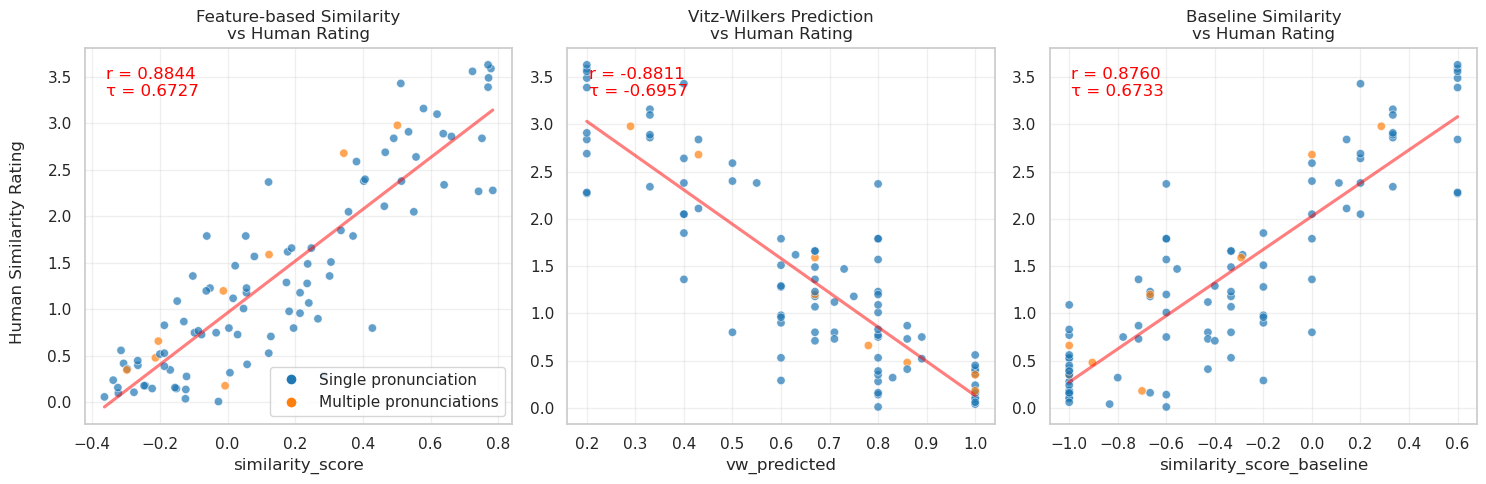

In [16]:
def create_comparison_grid(data):
    """Create a grid of 3 scatter plots comparing different similarity scores to human ratings."""
    
    # Set up the figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Helper function to create scatter plot with regression line and correlation
    def plot_comparison(ax, x_col, y_col='obtained', title=''):
        # Create color mapping for points
        colors = ['#1f77b4' if n == 1 else '#ff7f0e' for n in data['n_cmudict_variations']]
        
        # Scatter plot with different colors
        sns.scatterplot(data=data, x=x_col, y=y_col, ax=ax, alpha=0.7,
                       c=colors, legend=False)
        
        # Add regression line
        sns.regplot(data=data, x=x_col, y=y_col, ax=ax,
                   scatter=False, line_kws={'color': 'red', 'alpha': 0.5},
                   ci=None)
        
        # Calculate correlations
        r, _ = stats.pearsonr(data[x_col], data[y_col])
        tau, _ = stats.kendalltau(data[x_col], data[y_col])
        
        # Add correlation coefficients
        ax.text(0.05, 0.95, f'r = {r:.4f}\nτ = {tau:.4f}',
                color='red',
                transform=ax.transAxes,
                verticalalignment='top')
        
        # Customize plot
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        
        # Remove y-axis label since we have a common one
        ax.set_ylabel('')
        
        # Add legend if this is the first plot
        if ax == ax1:
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor='#1f77b4', label='Single pronunciation',
                          markersize=8),
                plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='#ff7f0e', label='Multiple pronunciations',
                          markersize=8)
            ]
            ax.legend(handles=legend_elements, loc='lower right')
    
    # Create the three plots
    plot_comparison(ax1, 'similarity_score', 
                   title='Feature-based Similarity\nvs Human Rating')
    plot_comparison(ax2, 'vw_predicted',
                   title='Vitz-Wilkers Prediction\nvs Human Rating')
    plot_comparison(ax3, 'similarity_score_baseline',
                   title='Baseline Similarity\nvs Human Rating')
    
    # Adjust layout first
    plt.tight_layout()
    
    # Add common y-axis label with adjusted position
    fig.text(0.01, 0.5, 'Human Similarity Rating', 
             va='center', rotation='vertical')
    
    # Add extra space on the left for the label
    plt.subplots_adjust(left=0.06)
    
    plt.show()

# Create the comparison grid
create_comparison_grid(vw_data)

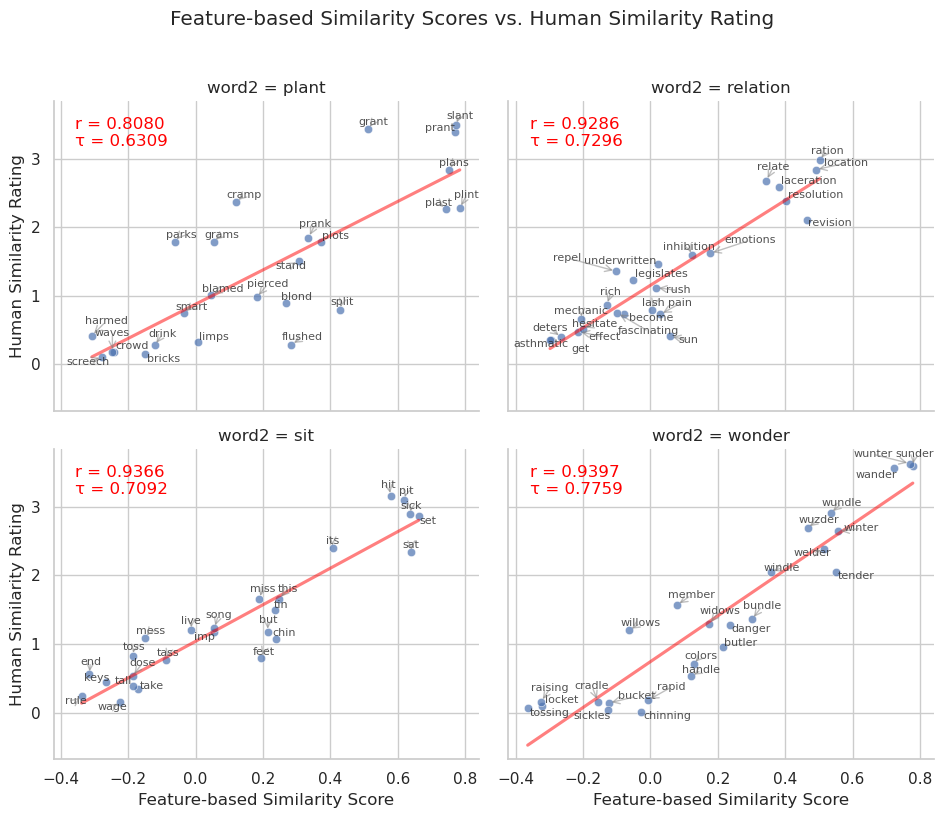

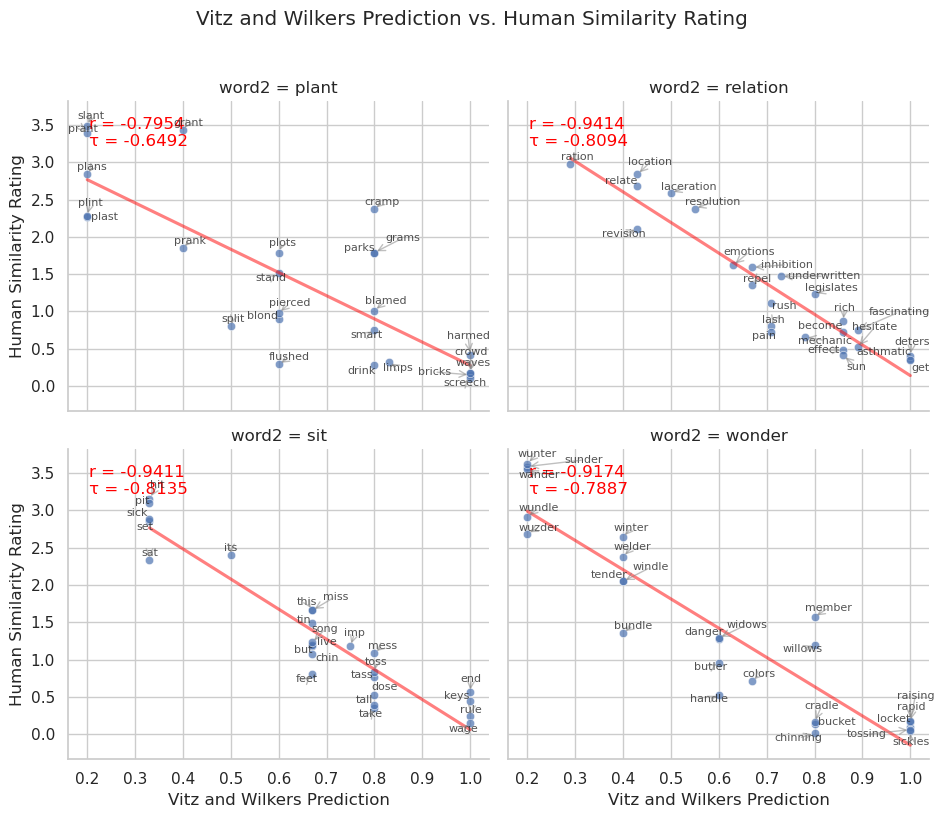

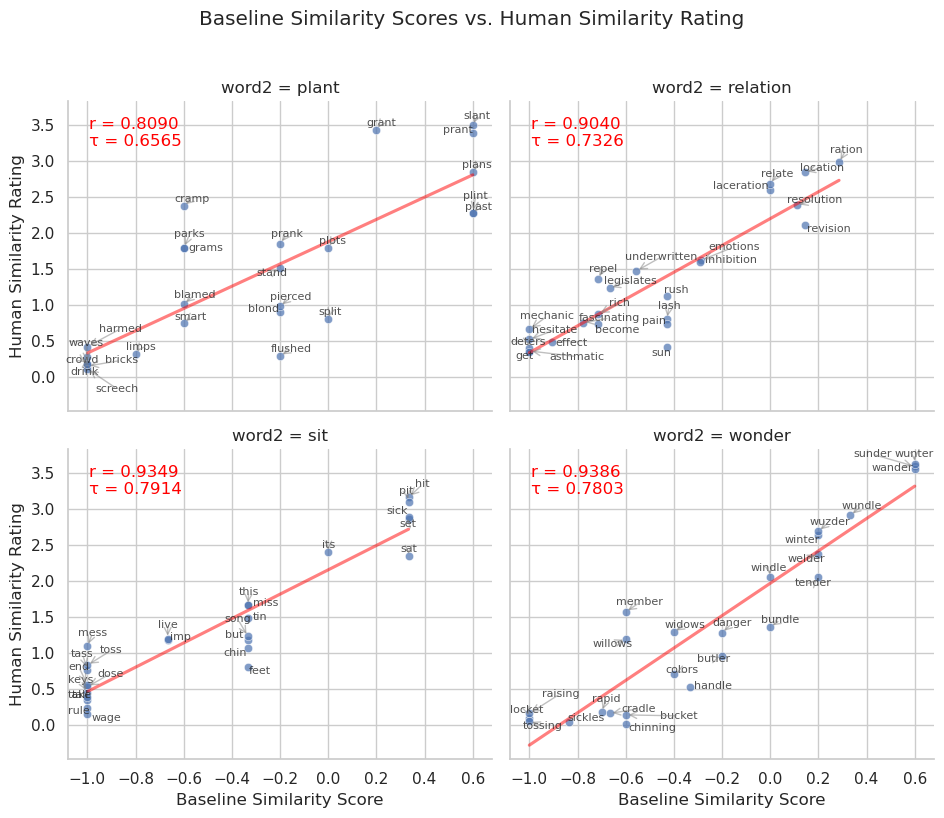

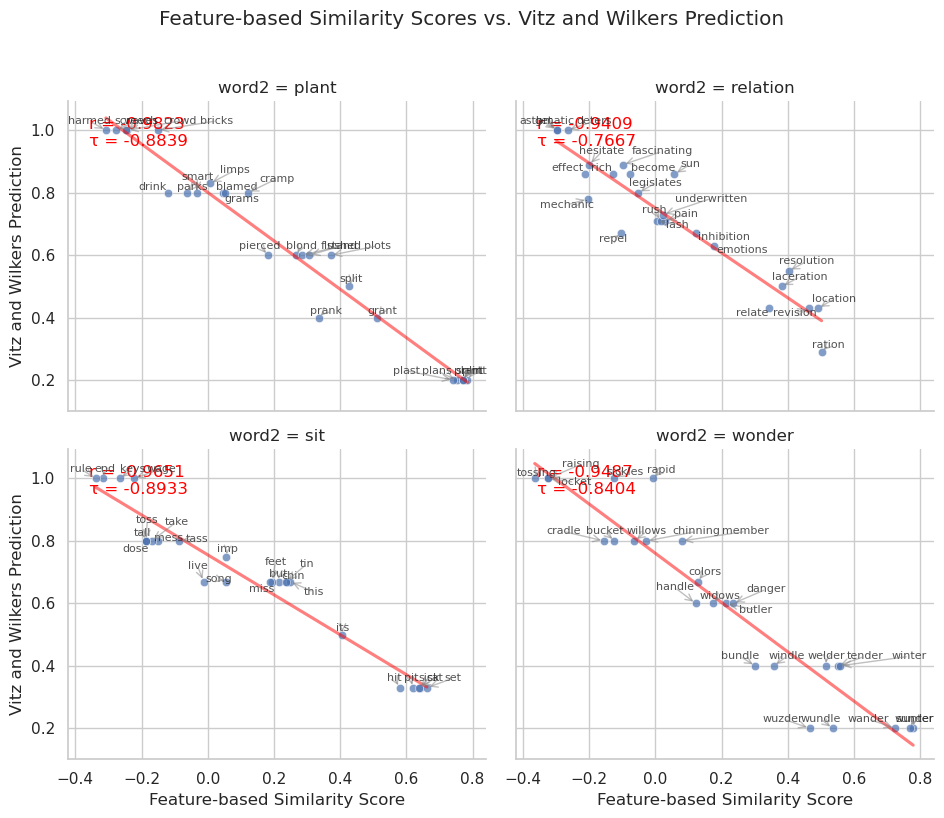

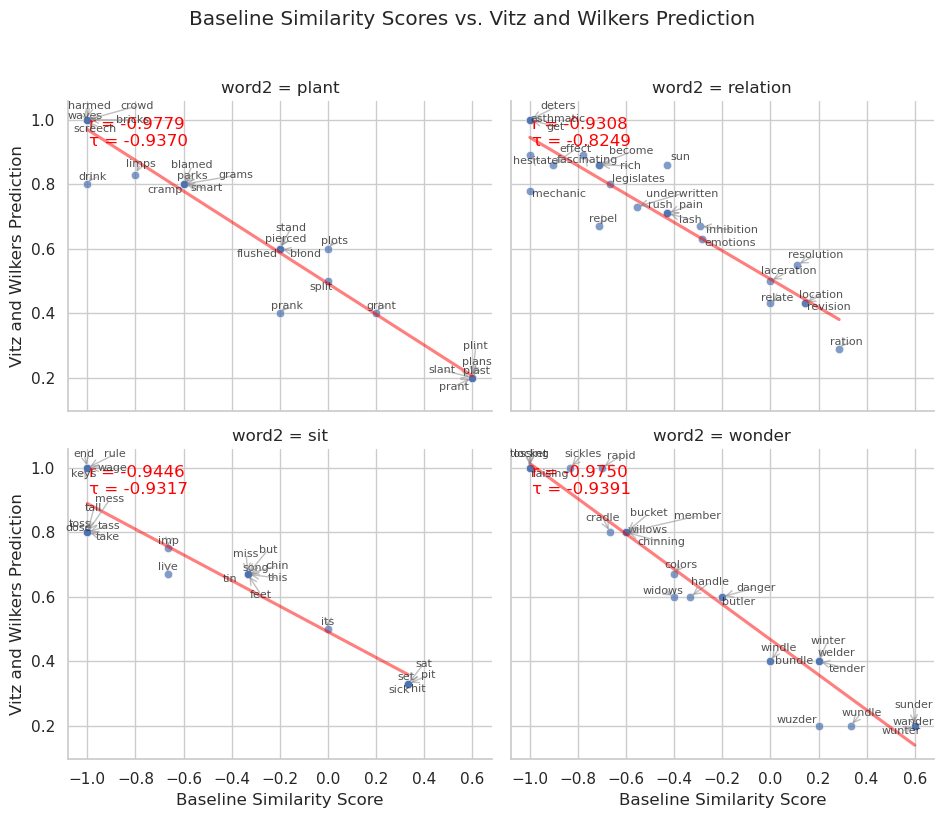

In [17]:
def create_faceted_scatter(data, x_col, y_col, title, 
                           x_label=None, y_label=None):
    """Create a faceted scatter plot with regression lines and point labels.
    
    Args:
        data: pandas DataFrame containing the data
        x_col: name of column to plot on x-axis
        y_col: name of column to plot on y-axis 
        title: plot title
        x_label: x-axis label (defaults to x_col if None)
        y_label: y-axis label (defaults to y_col if None)
    """
    # Create faceted scatter plot
    g = sns.FacetGrid(
        data=data.to_pandas(), 
        col='word2',
        col_wrap=2,
        height=4,
        aspect=1.2
    )
    
    # Add scatter plots and regression lines to each panel
    def plot_with_stats(data, **kwargs):
        # Scatter plot
        sns.scatterplot(data=data, x=x_col, y=y_col, alpha=0.7)
        
        # Calculate correlation and add regression line
        r, _ = stats.pearsonr(data[x_col], data[y_col])
        tau, _ = stats.kendalltau(data[x_col], data[y_col])
        
        sns.regplot(data=data, x=x_col, y=y_col,
                   scatter=False, line_kws={'color': 'red', 'alpha': 0.5},
                   ci=None)
        
        # Add correlation text
        plt.text(0.05, 0.95, f'r = {r:.4f}\nτ = {tau:.4f}',
                color='red', 
                transform=plt.gca().transAxes,
                verticalalignment='top')
    
    g.map_dataframe(plot_with_stats)
    
    # Add text labels with overlap adjustment
    def label_points(data, **kwargs):
        texts = []
        for idx, row in data.iterrows():
            texts.append(plt.text(
                row[x_col],
                row[y_col],
                row['word1'],
                fontsize=8,
                alpha=0.8,
                ha='center',
                va='bottom'
            ))
        with open(os.devnull, 'w') as fnull:
            with redirect_stdout(fnull):
                adjust_text(
                    texts,
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
                    expand_points=(1.5, 1.5),
                    only_move={'points':'y', 'texts':'y'}
                )
    
    g.map_dataframe(label_points)
    
    # Customize the plot
    g.set_axis_labels(x_label or x_col, y_label or y_col)
    g.fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# Usage examples:
create_faceted_scatter(
    vw_data,
    x_col='similarity_score',
    y_col='obtained',
    title='Feature-based Similarity Scores vs. Human Similarity Rating',
    x_label='Feature-based Similarity Score',
    y_label='Human Similarity Rating',
)

create_faceted_scatter(
    vw_data, 
    x_col='vw_predicted',
    y_col='obtained',
    title='Vitz and Wilkers Prediction vs. Human Similarity Rating',
    x_label='Vitz and Wilkers Prediction',
    y_label='Human Similarity Rating',
)

create_faceted_scatter(
    vw_data,
    x_col='similarity_score_baseline',
    y_col='obtained',
    title='Baseline Similarity Scores vs. Human Similarity Rating',
    x_label='Baseline Similarity Score',
    y_label='Human Similarity Rating',
)

create_faceted_scatter(
    vw_data,
    x_col='similarity_score',
    y_col='vw_predicted',
    title='Feature-based Similarity Scores vs. Vitz and Wilkers Prediction',
    x_label='Feature-based Similarity Score',
    y_label='Vitz and Wilkers Prediction',
)

create_faceted_scatter(
    vw_data,
    x_col='similarity_score_baseline',
    y_col='vw_predicted',
    title='Baseline Similarity Scores vs. Vitz and Wilkers Prediction',
    x_label='Baseline Similarity Score',
    y_label='Vitz and Wilkers Prediction',
)


In [13]:
def find_similarity_outliers(data):
    """Find word pairs where feature-based similarity deviates most from human ratings.
    
    Args:
        data: DataFrame with word pairs and scores
        n_outliers: Number of top outliers to return
    """
    # Fit regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        data['similarity_score'], 
        data['obtained']
    )
    
    # Calculate predicted values and residuals
    predicted = slope * data['similarity_score'] + intercept
    residuals = data['obtained'] - predicted
    
    # Add residuals to dataframe and sort by absolute value
    outliers = data.with_columns(
        pl.Series('residual', residuals),
        pl.Series('predicted', predicted)
    ).sort('residual', descending=True)
    
    # Select and format relevant columns
    return outliers.select([
        'word1', 
        'word2',
        'similarity_score',
        'obtained',
        'predicted',
        'residual'
    ]).sort('residual', descending=True)

# Find and display outliers
outliers = find_similarity_outliers(vw_data)
print("Word pairs where feature-based similarity deviates most from human ratings:")
print("\nPositive residuals (human rating higher than predicted):")
display(outliers.head(10))
print("\nNegative residuals (human rating lower than predicted):")
display(outliers.tail(10))

Word pairs where feature-based similarity deviates most from human ratings:

Positive residuals (human rating higher than predicted):


shape: (10, 6)
┌────────────┬──────────┬──────────────────┬──────────┬───────────┬──────────┐
│ word1      ┆ word2    ┆ similarity_score ┆ obtained ┆ predicted ┆ residual │
│ ---        ┆ ---      ┆ ---              ┆ ---      ┆ ---       ┆ ---      │
│ str        ┆ str      ┆ f64              ┆ f64      ┆ f64       ┆ f64      │
╞════════════╪══════════╪══════════════════╪══════════╪═══════════╪══════════╡
│ cramp      ┆ plant    ┆ 0.121            ┆ 2.37     ┆ 1.301332  ┆ 1.068668 │
│ grant      ┆ plant    ┆ 0.512            ┆ 3.43     ┆ 2.388378  ┆ 1.041622 │
│ parks      ┆ plant    ┆ -0.061673        ┆ 1.79     ┆ 0.793471  ┆ 0.996529 │
│ relate     ┆ relation ┆ 0.343448         ┆ 2.68     ┆ 1.919775  ┆ 0.760225 │
│ repel      ┆ relation ┆ -0.102909        ┆ 1.36     ┆ 0.678826  ┆ 0.681174 │
│ grams      ┆ plant    ┆ 0.0535           ┆ 1.79     ┆ 1.11367   ┆ 0.67633  │
│ ration     ┆ relation ┆ 0.501877         ┆ 2.98     ┆ 2.360234  ┆ 0.619766 │
│ hit        ┆ sit      ┆ 0.579167         ┆ 3.16     ┆ 2.575113  ┆ 0.584887 │
│ wander     ┆ wonder   ┆ 0.724            ┆ 3.56     ┆ 2.977775  ┆ 0.582225 │
│ laceration ┆ relation ┆ 0.38098          ┆ 2.59     ┆ 2.024121  ┆ 0.565879 │
└────────────┴──────────┴──────────────────┴──────────┴───────────┴──────────┘


Negative residuals (human rating lower than predicted):


shape: (10, 6)
┌──────────┬──────────┬──────────────────┬──────────┬───────────┬───────────┐
│ word1    ┆ word2    ┆ similarity_score ┆ obtained ┆ predicted ┆ residual  │
│ ---      ┆ ---      ┆ ---              ┆ ---      ┆ ---       ┆ ---       │
│ str      ┆ str      ┆ f64              ┆ f64      ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════════════╪══════════╪═══════════╪═══════════╡
│ feet     ┆ sit      ┆ 0.195            ┆ 0.8      ┆ 1.507065  ┆ -0.707065 │
│ sun      ┆ relation ┆ 0.05761          ┆ 0.41     ┆ 1.125098  ┆ -0.715098 │
│ plast    ┆ plant    ┆ 0.742            ┆ 2.27     ┆ 3.027818  ┆ -0.757818 │
│ rapid    ┆ wonder   ┆ -0.007509        ┆ 0.18     ┆ 0.944055  ┆ -0.764055 │
│ handle   ┆ wonder   ┆ 0.121595         ┆ 0.53     ┆ 1.302985  ┆ -0.772985 │
│ blond    ┆ plant    ┆ 0.267            ┆ 0.9      ┆ 1.707237  ┆ -0.807237 │
│ plint    ┆ plant    ┆ 0.784            ┆ 2.28     ┆ 3.144585  ┆ -0.864585 │
│ chinning ┆ wonder   ┆ -0.027173        ┆ 0.01     ┆ 0.889386  ┆ -0.879386 │
│ split    ┆ plant    ┆ 0.427827         ┆ 0.8      ┆ 2.154364  ┆ -1.354364 │
│ flushed  ┆ plant    ┆ 0.2845           ┆ 0.29     ┆ 1.75589   ┆ -1.46589  │
└──────────┴──────────┴──────────────────┴──────────┴───────────┴───────────┘

Vitz and Wilkers' work establishes a strong baseline for predicting perceptual similarity by comparing phonetic transcriptions. Their "Predicted Phonemic Distance" metric simply aligns phoneme transcriptions, minimizing edit distance, and counts the number of phonemes that differ. All substitutions and insertions/deletions are penalized equally, which the authors acknowledge as an oversimplification.

> "Our interpretation is that relatively little of the variance in the rating of complete words is due to factors existing at a lower or more molecular level than the phoneme. The phoneme certainly accounts for a large amount of the variance but it is probable that most of the remaining variance is at a still higher level."

*Oversimplification or not, VW outperforms my own feature-based similarity scores in predicting human similarity ratings in 50% of cases, with higher overall correlations to human similarity ratings.*



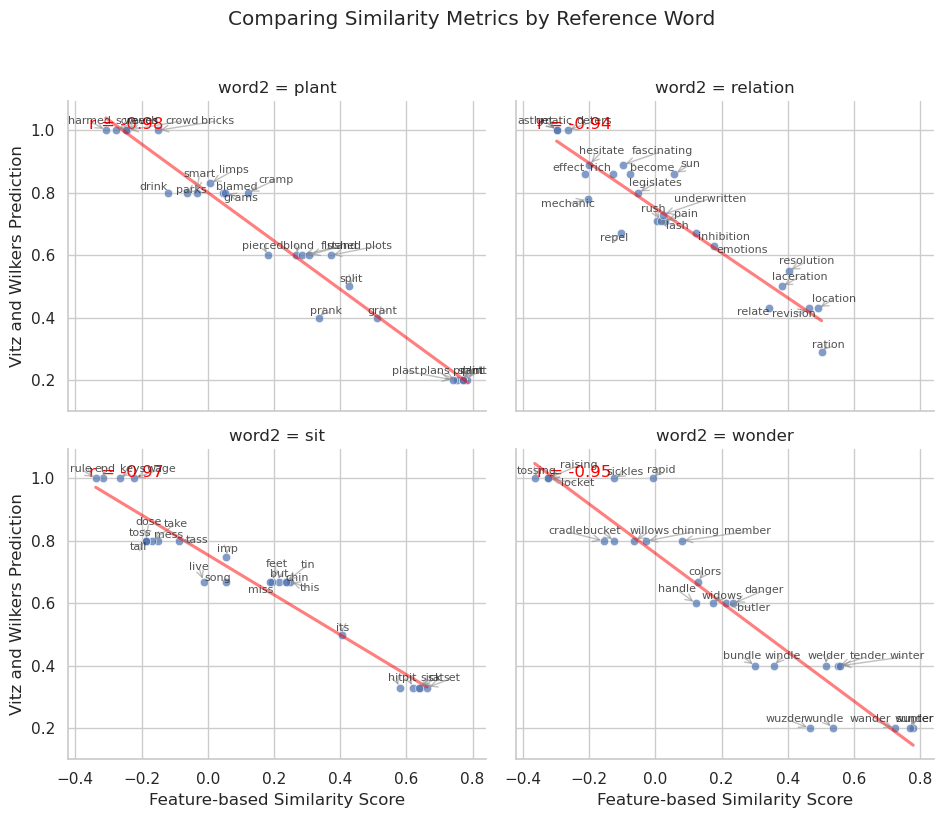

In [14]:
# Create faceted scatter plot
g = sns.FacetGrid(
    data=vw_data.to_pandas(), 
    col='word2',
    col_wrap=2,
    height=4,
    aspect=1.2
)

# Add scatter plots and regression lines to each panel
def plot_with_stats(data, **kwargs):
    # Scatter plot
    sns.scatterplot(data=data, x='similarity_score', y='vw_predicted', alpha=0.7)
    
    # Calculate correlation and add regression line
    r, _ = stats.pearsonr(data['similarity_score'], data['vw_predicted'])
    sns.regplot(data=data, x='similarity_score', y='vw_predicted', 
                scatter=False, line_kws={'color': 'red', 'alpha': 0.5},
                ci=None)
    
    # Add correlation text
    plt.text(0.05, 0.95, f'r = {r:.2f}',
             color='red',
             transform=plt.gca().transAxes,
             verticalalignment='top')

g.map_dataframe(plot_with_stats)

# Add text labels with overlap adjustment
def label_points(data, **kwargs):
    texts = []
    for idx, row in data.iterrows():
        texts.append(plt.text(
            row['similarity_score'], 
            row['vw_predicted'], 
            row['word1'],
            fontsize=8,
            alpha=0.8,
            ha='center',
            va='bottom'
        ))
    with open(os.devnull, 'w') as fnull:
        with redirect_stdout(fnull):
            adjust_text(
                texts,
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
                expand_points=(1.5, 1.5),
                only_move={'points':'y', 'texts':'y'}
            )

g.map_dataframe(label_points)

# Customize the plot
g.set_axis_labels('Feature-based Similarity Score', 'Vitz and Wilkers Prediction')
g.fig.suptitle('Comparing Similarity Metrics by Reference Word', y=1.02)
plt.tight_layout()
plt.show()

## Evaluation
Evaluating how well feature-based similary scores predict perceived word-level phonetic similarity is difficult and labor intensive. Previous phonetic similarity research has leveraged experiments conducted by Vitz and Wilkers (1973), in which subjects were presented with two words in sequence and asked to rate their similarity on a subjective 1-4 scale. Vitz and Wilkers then assessed whether their theoretical model of phonetic similarity, based on phonological features, matched listener judgments.

The [Vitz and Wilkers experimental data](https://github.com/zouharvi/pwesuite/blob/master/data/human_similarity.csv) is available via the PWEsuite evaluation package published by Zouhar et al 2024 in [the GitHub repository](https://github.com/zouhar/pwe-suite) accompanying their paper. This same data was used by Allison Parrish to evaluate the quality of her [Poetic Sound Similarity Vectors using Phonetic Features](https://github.com/aparrish/phonetic-similarity-vectors/).



## From phonemes to pronunciations
So now we have a way to measure the similarity between two phonemes. But how do we measure the similarity between two pronunciations?

If the pronunciations are the same length, it's easy: we can just add up the similarity scores for each phoneme pair and divide by the number of phoneme pairs. But what if the pronunciations are different lengths? How do we determine which phoneme pairs "align" and which phonemes represent insertions or deletions?

To resolve this problem we can borrow a technique from bioinformatics: the [Needleman-Wunsch algorithm](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm). This algorithm is used to align two sequences of DNA or protein sequences, and works by finding the optimal alignment between two sequences by considering all possible alignments and scoring them based on similarity.

## Building a substitution matrix
In order to use the Needleman-Wunsch algorithm to align phoneme sequences, we need to build a [substitution matrix](https://en.wikipedia.org/wiki/Substitution_matrix) from our feature-based similarity scores. It is possible to use Needleman-Wunsch without a substitution matrix by using the same penalty for all substitutions[^3]. When applied to phoneme sequences, however, a constant penalty results in a combinatorial explosion of possible optimal alignments with uninformative similarity scores.

The off-diagonal entries of this matrix represent the "cost" of substituting one phoneme for another, which is lower (less negative) the more similar the two phonemes are. The diagonal entries represent how much the similarity score improves as a result of matching the same phoneme in both pronunciations. 

Additionally, Needleman-Wunsch incorporates a "gap penalty" that determines how much the similarity score degrades as a result of matching a phoneme in one pronunciation with a gap in the other pronunciation (an "insertion" or "deletion"). Empirically some phonemes are more likely to be dropped than others, but we can't determine this from feature-based similarity scores alone.

**While I won't be implementing or applying Needleman-Wunsch here, we can use the substitution matrix here to visualize the pairwise similarity across all phonemes in a single heatmap chart.**

:::tip[using Needleman-Wunsch to align pronunciations]
*I'll insert a link to the next article in this series, on using Needleman-Wunsch to align pronunciations, here once it's published.*
:::

[^3]: Needleman-Wunsch with constant penalties is essentially equivalent to [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance), which is a measure of the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one sequence into another.


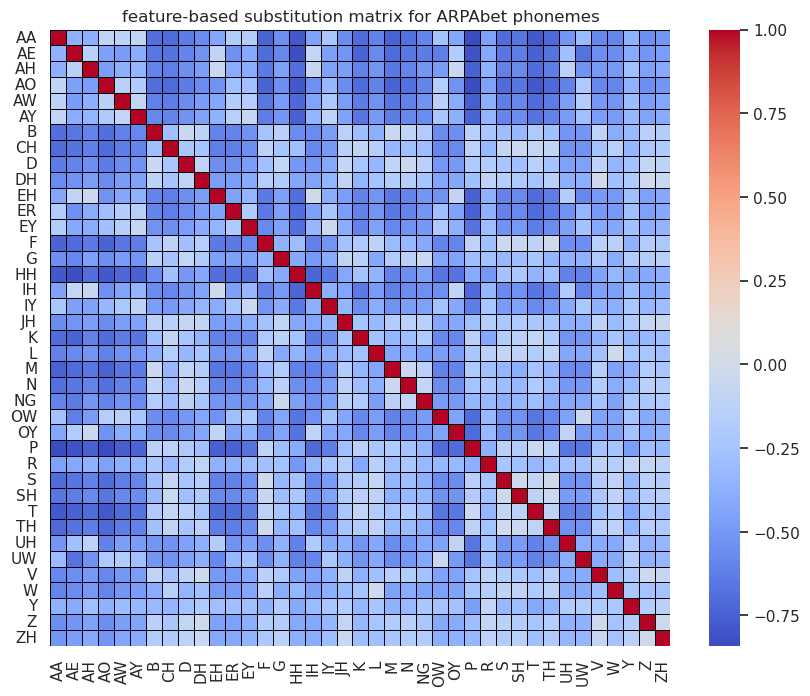

In [15]:
# fill in substitution matrix with feature-based similarity scores
sub_mtx = np.zeros((len(phonemes), len(phonemes)))
for i, phoneme1 in enumerate(phonemes):    
    for j, phoneme2 in enumerate(phonemes):
        score = phonetic_feature_based_similarity_score(phoneme1, phoneme2)
        if phoneme1 != phoneme2:
            # mismatch scores are <similarity score> - 100, 
            #   so that substitutions between more similar pairs incur a smaller penalty
            score -= base_score
        sub_mtx[i, j] = score

# divide by base_score to get scores in [0, 1]
sub_mtx = sub_mtx / base_score

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sub_mtx, xticklabels=phonemes, yticklabels=phonemes, cmap='coolwarm', linewidths=0.5, linecolor='black');
plt.title('feature-based substitution matrix for ARPAbet phonemes')
plt.show()

# housekeeping: save similarity matrix as a numpy array in current directory for use in next notebook.
np.save('phoneme_feature_based_substitution_matrix.npy', sub_mtx)

## Conclusion & next steps
Personally, I don't find the phonetics-derived similarity scores we computed in this article to be as intuitive as I had hoped.


The feature-based phoneme similarity scores we computed in this article, and visualized in the heatmap above, are most useful as groundwork for aligning pronunciations to count substitutions in the "decoder error"-based approach that I ultimately chose as the most suitable for measuring pronunciation similarity. **The best use of feature-based similarity scores is to align different pronunciations of the same word to count substitutions.**

In practice, feature-based similarity scores don't produce interesting similarity rankings for name pronunciations because there are too many ties and because there's no obvious way to measure how likely a phoneme is to be omitted from a pronunciation. There are too many parwise phoneme comparisons in our substitution matrix (1600 in all including gaps) for linguists to produce properly nuanced similarity rankings based on subject-matter expertise. Moreover, considering phonemes in isolation misses phenomena like the "flap T" or [unreleased stop](https://en.wikipedia.org/wiki/No_audible_release), where "T" can sometimes sound like "D" when it appears between vowels (e.g. "party" sounds like "pardy").

**The rather unsatisfying answer from this investigation is that, even within a single language, theoretical linguistics doesn't offer an objective way to measure how similar two sounds are, much less how similar two pronunciations are.** The theoretical basis for using features from Articulatory Phonetics is that sounds which are produced in a similar way are more likely to be confused by the speaker, which is a shaky foundation when you consider that what we're really trying to measure is how similar two sounds seem to the listener.

In the next article in this series, I'm going to walk through using the Needleman-Wunsch algorithm to align pronunciations of the same word to count substitutions and calibrate those counts into a matrix we can use to rank the similarity of any two pronunciations.

## References
Bailey, Todd M., and Ulrike Hahn. 2005. “Phoneme Similarity and Confusability.” Journal of Memory and Language 52 (3): 339–62. https://doi.org/10.1016/j.jml.2004.12.003.

Kondrak, Grzegorz. 2002. “Algorithms for Language Reconstruction.” https://webdocs.cs.ualberta.ca/~kondrak/papers/thesis.pdf.

Ruiz, Pablo, Aitor Álvarez, and Haritz Arzelus. 2014. “Phoneme Similarity Matrices to Improve Long Audio Alignment for Automatic Subtitling.” International Conference on Language Resources and Evaluation, May, 437–42. http://www.lrec-conf.org/proceedings/lrec2014/pdf/387_Paper.pdf.

“Phoneme Similarity Matrices.” n.d. Accessed January 8, 2025. https://sites.google.com/site/similaritymatrices/.